In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
import sys
sys.path.append('..')

import GaussianODEs as ode
import MultivariateGaussianAlgorithms as algo
importlib.reload(ode)
importlib.reload(algo)

<module 'MultivariateGaussianAlgorithms' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Gaussian/MultivariateGaussianAlgorithms.py'>

In [2]:
d = 1

In [3]:
ms = 1*np.ones(d)
Sigmas = 5*np.eye(d)
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

In [4]:
Sigmas_inv = linalg.inv(Sigmas)

## WFR

In [5]:
Niter = 1000
gamma = 0.01
mean_eq_wfr, var_eq_wfr, kl_wfrinf = ode.wfr_infinite_time(mu0, ms, Sigma0, Sigmas, Niter, gamma)

In [6]:
N = 1000
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)

In [7]:
x, W = algo.SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, 1)

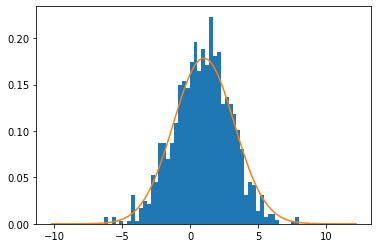

In [8]:
mu = ms[0]
sigma = Sigmas[0]

plt.hist(x[-1, 0, :], density = True, weights = W[-1, :], bins = 50)
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))

In [9]:
mean_smc = np.zeros(Niter)
var_smc = np.zeros(Niter)
kl_smc = np.zeros(Niter)
for i in range(Niter):
    mean_smc[i] = np.sum(x[i, 0, :]*W[i, :])
    var_smc[i] = np.sum(x[i, 0, :]**2*W[i, :]) - mean_smc[i]**2
    kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_18536/206939111.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)


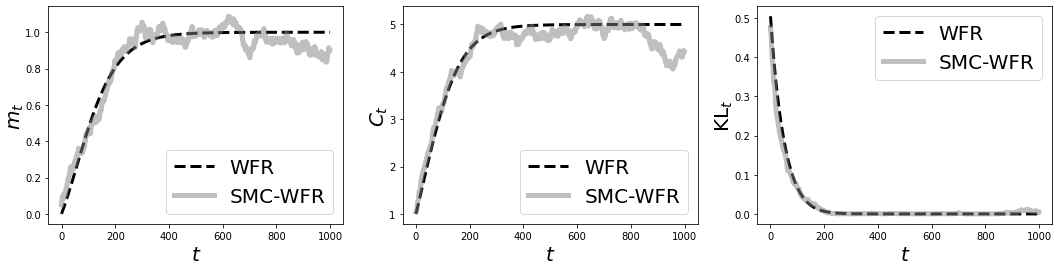

In [10]:
plt.figure(figsize = (18, 4))
plt.subplot(1, 3, 1)
plt.plot(mean_eq_wfr, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(mean_smc, label = 'SMC-WFR', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$m_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
plt.subplot(1, 3, 2)
plt.plot(var_eq_wfr, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(var_smc, label = 'SMC-WFR', color = 'gray', alpha = 0.5, lw = 5)
plt.legend(fontsize = 20)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$C_t$', fontsize = 20, labelpad=-1)
plt.subplot(1, 3, 3)
plt.plot(kl_wfrinf, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(kl_smc, label = 'SMC-WFR', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
# plt.savefig('SMC_WFR_gaussian.pdf', bbox_inches="tight")

## Unit time FR

In [11]:
mean_eq_fr, var_eq_fr, kl_fr = ode.fisherrao_infinite_time(mu0, ms, Sigma0, Sigmas, Niter, gamma)

In [12]:
xSMC, WSMC = algo.SMC_UnitFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, 1)

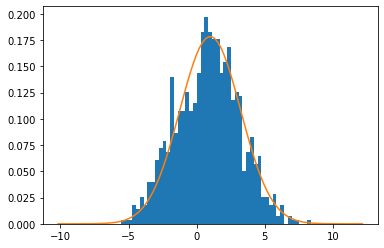

In [13]:
plt.hist(xSMC[-1, 0, :], density = True, weights = WSMC[-1, :], bins = 50)
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))

In [14]:
mean_smc = np.zeros(Niter)
var_smc = np.zeros(Niter)
kl_smc = np.zeros(Niter)
for i in range(Niter):
    mean_smc[i] = np.sum(xSMC[i, 0, :]*WSMC[i, :])
    var_smc[i] = np.sum(xSMC[i, 0, :]**2*WSMC[i, :]) - mean_smc[i]**2
    kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_18536/3773519912.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)


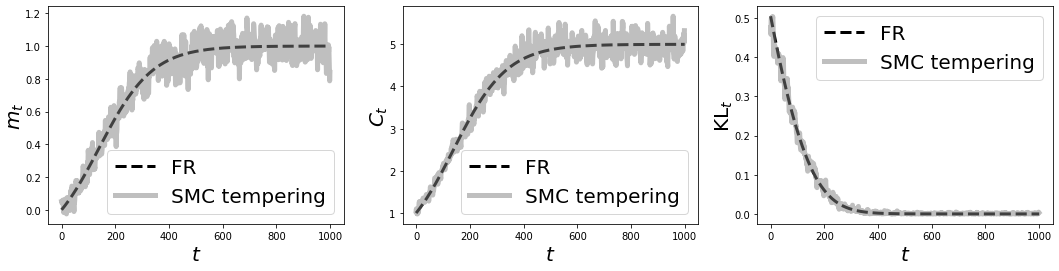

In [15]:
plt.figure(figsize = (18, 4))
plt.subplot(1, 3, 1)
plt.plot(mean_eq_fr, label = 'FR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(mean_smc, label = 'SMC tempering', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$m_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
plt.subplot(1, 3, 2)
plt.plot(var_eq_fr, label = 'FR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(var_smc, label = 'SMC tempering', color = 'gray', alpha = 0.5, lw = 5)
plt.legend(fontsize = 20)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$C_t$', fontsize = 20, labelpad=-1)
plt.subplot(1, 3, 3)
plt.plot(kl_fr, label = 'FR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(kl_smc, label = 'SMC tempering', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
# plt.savefig('SMC_FR_gaussian.pdf', bbox_inches="tight")